In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset

In [5]:
path_to_db='../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]
    

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )

df = df[df.h_target == 1]
red_class = [classes[i] for i in df.target.unique()]
df.head()

,target,h_target,metadata,fold
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,3
5,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
6,30,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,58.190871,43.667121,45.746463,42.343447,30.084076,48.247964,42.374778,39.387926,37.159804,49.153997,...,-0.151783,0.248175,14.496725,14.949878,3.585011,29.220897,3.871622,1,36,4
1,57.661319,60.080983,44.186640,48.768903,42.526813,44.876951,34.971382,41.118424,38.246856,45.606720,...,-0.072586,-0.007093,9.667292,28.537172,4.993364,22.758403,4.793919,1,36,4
2,67.650573,73.408686,44.682788,55.750333,39.236220,40.627880,41.786830,46.499063,40.762930,43.984468,...,0.264036,-0.195292,9.728142,24.602081,5.701362,22.282521,4.545848,1,36,4
3,59.714913,55.872608,54.856162,51.512034,49.218383,55.968103,40.890560,44.236659,38.496857,45.733907,...,0.434551,0.186542,13.989773,22.096882,6.127154,19.936294,6.681744,1,36,4
4,65.404965,69.993503,56.847376,54.966564,42.476325,41.917453,43.411913,41.171589,35.436546,40.675832,...,-0.132112,-0.347691,9.866833,15.716688,5.070683,14.813657,3.730182,1,36,4


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,80.575255,66.725746,46.994181,47.306487,39.702270,29.614720,27.944058,21.878322,34.139762,34.921444,...,0.127173,0.225056,10.022619,11.752399,3.388319,18.399193,2.063419,1,22,1
1,95.996881,84.094114,73.466142,47.328877,39.542418,40.902191,33.085433,23.786444,32.360731,30.687556,...,0.245494,-0.208494,8.145473,11.237313,3.018750,18.749604,1.958891,1,22,1
2,87.630946,87.872741,61.568704,67.180224,48.864957,49.824350,50.399792,29.029703,39.580180,32.943774,...,0.272345,0.037201,7.394694,13.063212,3.005300,13.942061,2.637733,1,22,1
3,88.804114,83.845571,62.382948,56.884802,40.906413,43.594006,45.073716,39.831305,43.506318,37.453205,...,0.108370,-0.061122,7.522909,12.238525,3.638212,14.367419,2.891521,1,22,1
4,111.861869,74.672103,60.278798,66.625563,52.688622,49.828351,28.414318,40.278878,32.712182,33.494275,...,-0.324547,-0.284279,6.777737,14.154742,3.214716,13.068751,2.258633,1,22,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['target']

# Training

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import scipy

params = {
    'classify__n_estimators': range(5,100,1),
    'classify__criterion': ('gini', 'entropy'),
    'classify__max_depth': range(len(df.columns), 5 * len(df.columns)),
    'classify__max_features': ('log2', 'auto', None),
    'classify__oob_score': (True, False),
    'classify__warm_start': (True, False)
}

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=90, score_func=chi2)),
    ('feat_red', LinearDiscriminantAnalysis(n_components=20, solver='eigen')),
    ('classify', RandomForestClassifier(n_jobs=10, random_state=42))
])

randsrc = RandomizedSearchCV(
                clf,
                cv=10,
                refit=True,
                param_distributions = params,
                verbose=2,
                n_jobs=10,
                n_iter=100
)

randsrc.fit(train_X, train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   35.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 12.5min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 21.3min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 30.3min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function chi2 at 0x7f0f03291378>)), ('feat_red', LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), (...tors='warn', n_jobs=10,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=10,
          param_distributions={'classify__oob_score': (True, False), 'classify__max_features': ('log2', 'auto', None), 'classify__max_depth': range(4, 20), 'classify__criterion': ('gini', 'entropy'), 'classify__warm_start': (True, False), 'classify__n_estimators': range(5, 100)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [13]:
randsrc.best_estimator_ 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function chi2 at 0x7f0f03291378>)), ('feat_red', LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), (...timators=86, n_jobs=10,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [14]:
sorted(randsrc.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_classify__criterion',
 'param_classify__max_depth',
 'param_classify__max_features',
 'param_classify__n_estimators',
 'param_classify__oob_score',
 'param_classify__warm_start',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.3461791110137946
Confusion matrix, without normalization
[[ 71   2   1 ...   0   0   0]
 [  7  54   1 ...   0   0   0]
 [  6   6 113 ...   1   1   1]
 ...
 [  1  18   2 ...  48   1   0]
 [  1   1   5 ...   2  76   7]
 [  0   0   0 ...   0   0  61]]


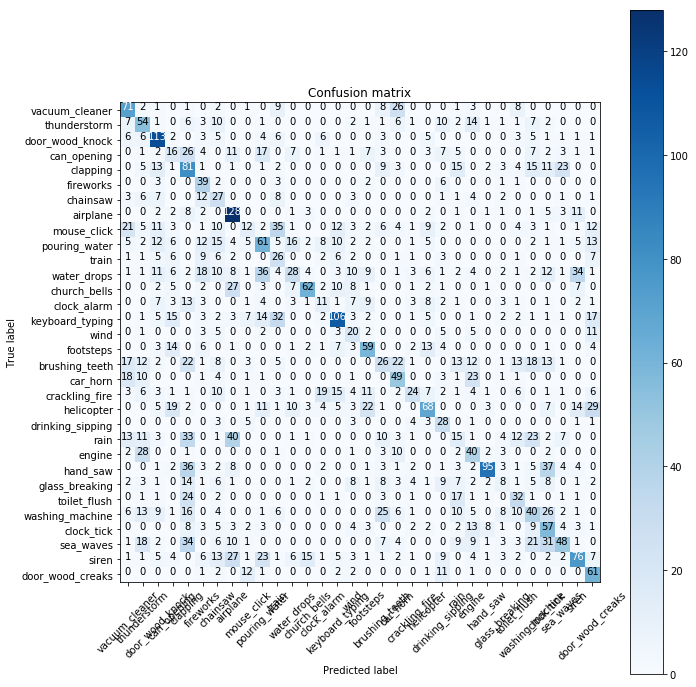

In [15]:
pred = randsrc.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

In [16]:
pred_prob = randsrc.predict_proba(test_X)

# All Data

In [17]:
import seaborn as sns
misclassified = {
    'actual': [],
    'predicted': []
}
for cls in red_class:
    misclassified[cls] = []

for row, p, prob, Y in zip(test.iterrows(), pred, pred_prob, test_y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['actual'].append(classes[int(row[1]['target'])])
        misclassified['predicted'].append(classes[p])
        for i, cls in enumerate(red_class):
            misclassified[cls].append(prob[i])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,actual,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,clapping,0.001912,0.001090,0.014970,0.000000,0.015992,0.000000,0.000000,0.036196,0.0,...,0.003295,0.000000,0.039711,0.000000,0.019336,0.035714,0.014445,0.003182,0.058096,0.032318
1,clapping,0.001292,0.003165,0.002852,0.000000,0.010574,0.000000,0.000000,0.053373,0.0,...,0.000000,0.000000,0.063039,0.000000,0.000809,0.066552,0.003424,0.018316,0.077275,0.009718
2,clapping,0.013108,0.001225,0.002629,0.000000,0.020349,0.000337,0.000919,0.088298,0.0,...,0.011796,0.000169,0.018352,0.000529,0.005113,0.039297,0.004250,0.038112,0.051575,0.038290
3,clapping,0.038650,0.007482,0.001981,0.012315,0.011514,0.025312,0.000465,0.021478,0.0,...,0.000506,0.000465,0.015568,0.000000,0.005123,0.155893,0.005836,0.016096,0.033963,0.019330
4,clapping,0.000643,0.026078,0.005131,0.000202,0.054539,0.002414,0.000000,0.002801,0.0,...,0.000000,0.011628,0.016779,0.000750,0.000506,0.064827,0.014164,0.037794,0.000420,0.031640


In [18]:
average_prob = misclassified.groupby('actual').mean()
average_prob.head()

,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,crackling_fire,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
actual,,,,,,,,,,,,,,,,,,,,,
airplane,0.046878,0.045811,0.007581,0.027756,0.031085,0.002869,0.103807,0.015417,0.090946,0.010053,...,0.077071,0.081300,0.010804,0.056459,0.044360,0.010966,0.020881,0.083356,0.005706,0.021317
brushing_teeth,0.017296,0.012442,0.050702,0.009403,0.067913,0.009050,0.005567,0.052935,0.009075,0.041802,...,0.006270,0.006410,0.039283,0.013060,0.021351,0.071433,0.013776,0.010224,0.026431,0.049841
can_opening,0.013972,0.004783,0.111375,0.004310,0.019991,0.021811,0.001049,0.076301,0.011595,0.040223,...,0.001874,0.001740,0.042357,0.001908,0.009555,0.015338,0.003871,0.004949,0.044308,0.050200
car_horn,0.017650,0.052443,0.009297,0.028331,0.036398,0.007578,0.065433,0.030762,0.055499,0.033196,...,0.058878,0.031463,0.018296,0.030100,0.040207,0.010857,0.026084,0.059003,0.014411,0.052047
chainsaw,0.005700,0.050400,0.003227,0.089505,0.039558,0.000411,0.039151,0.011455,0.034810,0.013215,...,0.058183,0.053643,0.005648,0.170294,0.028276,0.014206,0.058235,0.054450,0.002332,0.023978


In [19]:
average_prob = misclassified.groupby('predicted').mean()
average_prob

,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,crackling_fire,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
predicted,,,,,,,,,,,,,,,,,,,,,
airplane,0.072840,0.026607,0.004269,0.008329,0.015043,0.003344,0.143797,0.013994,0.062861,0.006770,...,0.099735,0.273755,0.010801,0.020130,0.031705,0.008814,0.007660,0.049944,0.003923,0.012862
brushing_teeth,0.009236,0.015946,0.017589,0.007237,0.045844,0.002649,0.003151,0.031261,0.011143,0.027905,...,0.007942,0.004667,0.017643,0.009016,0.028137,0.273066,0.035150,0.024944,0.013834,0.017178
can_opening,0.012666,0.009151,0.075539,0.006323,0.021273,0.020165,0.002078,0.071826,0.007151,0.042255,...,0.004607,0.003208,0.057892,0.003868,0.012292,0.010365,0.003026,0.004229,0.055001,0.038103
car_horn,0.028427,0.048656,0.011179,0.023230,0.024667,0.005461,0.070899,0.025218,0.067661,0.009911,...,0.073692,0.052704,0.017295,0.056606,0.035032,0.005016,0.016984,0.076923,0.011885,0.019991
chainsaw,0.004368,0.018791,0.005035,0.084535,0.070012,0.000479,0.011472,0.012660,0.023817,0.025576,...,0.018757,0.051603,0.007905,0.097188,0.022111,0.014596,0.030485,0.020613,0.004065,0.057944
church_bells,0.032886,0.031641,0.007190,0.008681,0.018151,0.002593,0.073647,0.013894,0.260196,0.006767,...,0.048377,0.073454,0.015046,0.021268,0.021348,0.009103,0.010901,0.078727,0.008586,0.017551
clapping,0.005146,0.021896,0.006931,0.016097,0.035263,0.010546,0.003605,0.046858,0.009294,0.038777,...,0.009250,0.004143,0.027038,0.021633,0.026213,0.042401,0.032227,0.020071,0.014260,0.046844
clock_alarm,0.006510,0.023093,0.015594,0.018920,0.032714,0.014702,0.005521,0.047177,0.013338,0.184329,...,0.014753,0.004197,0.035907,0.016980,0.038050,0.027981,0.027655,0.014793,0.030669,0.069835
clock_tick,0.012948,0.011854,0.059053,0.003734,0.015141,0.020617,0.007776,0.091593,0.015003,0.036262,...,0.006695,0.005416,0.042774,0.003854,0.007037,0.015491,0.005291,0.014827,0.034889,0.028537


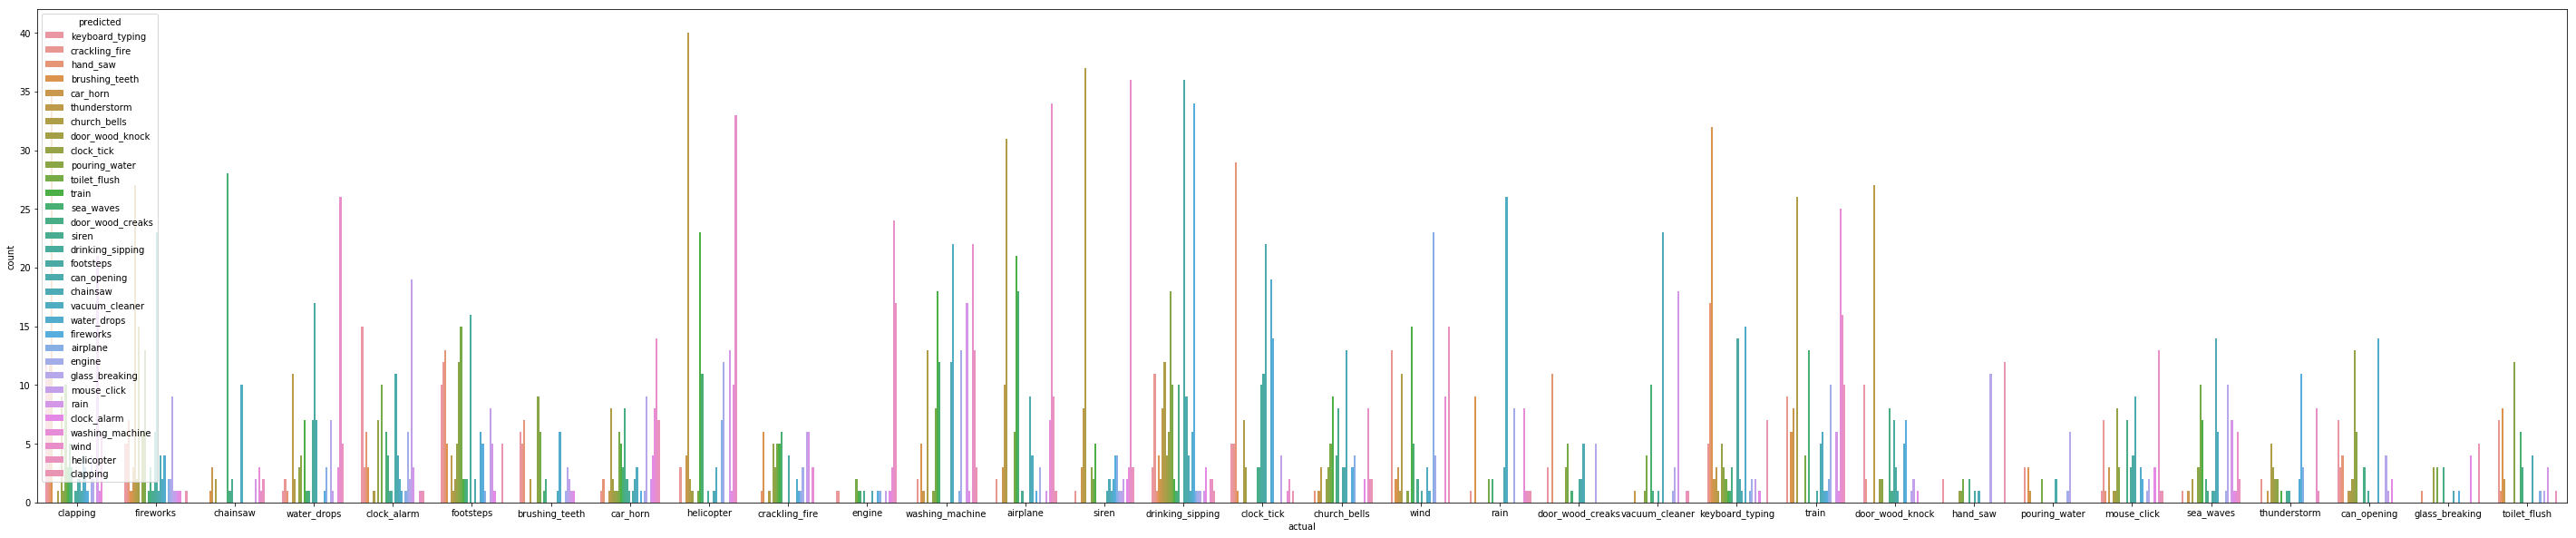

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='actual', hue='predicted',data=misclassified)